# Window function and amplitude correction

In [1]:
from radiocalibrationtoolkit import *
from scipy.signal import butter, lfilter
from scipy.signal import blackmanharris, boxcar, hann
from scipy.fft import rfft

[INFO] LFmap: Import successful.


In [2]:
# some global plot settings
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12

plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2

plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5

plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

## Examine effects on a single trace

In [3]:
N = 2048   # samples
fs_Hz = 250e6 # sampling frequency
signal_freq_Hz = 55.5e6 # signal
win = blackmanharris(N) # window function type

In [4]:
tx = np.arange(N) / fs_Hz
def make_simple_time_trace(signal_amplitude=0.7, signal_frequency=55.5e+6, noise_amplitude=1, N=2048, apply_filter=True):
    time_trace = signal_amplitude * np.sin(2*np.pi*signal_frequency*tx) + noise_amplitude * np.random.normal(size=N)
    b, a = butter(5, [30e6, 80e6], fs=250e6, btype='band')
    if apply_filter:
        time_trace = lfilter(b, a, time_trace)
    return np.round(time_trace * N) / N

Text(0, 0.5, 'amplitude [ADC]')

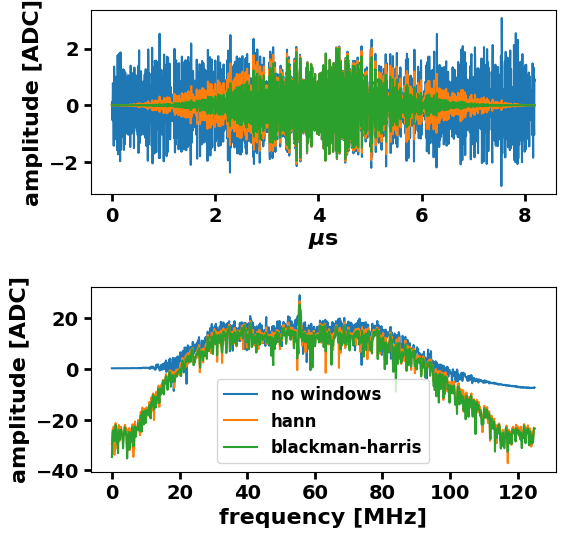

In [5]:
tt = make_simple_time_trace(signal_amplitude=1)
fx = np.fft.rfftfreq(N, 1/fs_Hz)*1e-6

fig, ax = plt.subplots(2,1, figsize=(6,6))
labels = ['no windows', 'hann', 'blackman-harris']
for i, w in enumerate([1, hann(N), blackmanharris(N)]):
    ax[0].plot(tx*1e+6, tt*w)
    ax[1].plot(fx, 10*np.log10(np.abs(np.fft.rfft(tt*w))), label=labels[i])

fig.subplots_adjust(hspace=0.5)
ax[1].legend()

ax[0].set_xlabel("$\mu$s")
ax[1].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("amplitude [ADC]")
ax[1].set_ylabel("amplitude [ADC]")


In [6]:
# generate time trace
time_trace = make_simple_time_trace()

# calculate two sided spectrum
spectrum = np.abs(fft(time_trace))
# calculate one sided spectrum (not corrected for the one side)
rspectrum = np.abs(np.fft.rfft(time_trace))

# calculate one sided spectrum (corrected for the one side)
r2spectrum = correct_energy_of_one_sided_spectrum(rspectrum)

# calculate amplitude window function correction
Aw = N/np.sum(win) /np.sqrt(2)

# calculate two sided spectrum using a window function (not corrected for the one side)
spectrum_w = np.abs(fft(time_trace*win))
# calculate one sided spectrum using a window function (not corrected for the one side)
rspectrum_w = np.abs(np.fft.rfft(time_trace*win))

# calculate one sided spectrum (corrected for the one side)
r2spectrum = correct_energy_of_one_sided_spectrum(rspectrum)
r2spectrum_w = correct_energy_of_one_sided_spectrum(rspectrum_w)

# define X-axis values
fx = np.fft.rfftfreq(N, 1/fs_Hz)/1e+6

In [7]:
# calculate energy from time trace, one and two sided spectrum with and without window
# when the window is used, the amplitudes are corrected
print(
    f"Energy calculated from:\n"
    f"time trace = {get_energy_from_time_trace(time_trace):.2f},\n"
    f"two sided spectrum = {get_energy_from_two_sided_spectrum(spectrum):.2f},\n"
    f"one sided spectrum = {get_energy_from_one_sided_spectrum(rspectrum):.2f},\n"
    f"windowed two sided spectrum = {get_energy_from_two_sided_spectrum(spectrum_w):.2f},\n"
    f"one sided spectrum corrected for being the one sided spectrum = {get_energy_from_one_sided_spectrum_corrected4one_side(r2spectrum):.2f},\n"
    f"windowed two sided spectrum corrected by window function loss = {get_energy_from_two_sided_spectrum(spectrum_w * Aw):.2f},\n"
    f"windowed one sided spectrum corrected by window function loss = {get_energy_from_one_sided_spectrum(rspectrum_w * Aw):.2f},\n"
    f"one sided spectrum corrected for being the one sided spectrum and for window function loss = {get_energy_from_one_sided_spectrum_corrected4one_side(r2spectrum_w*Aw):.2f},\n"
)

Energy calculated from:
time trace = 1332.59,
two sided spectrum = 1332.59,
one sided spectrum = 1332.59,
windowed two sided spectrum = 337.56,
one sided spectrum corrected for being the one sided spectrum = 1332.59,
windowed two sided spectrum corrected by window function loss = 1312.67,
windowed one sided spectrum corrected by window function loss = 1312.67,
one sided spectrum corrected for being the one sided spectrum and for window function loss = 1312.67,



### Trace with a broad band pulse

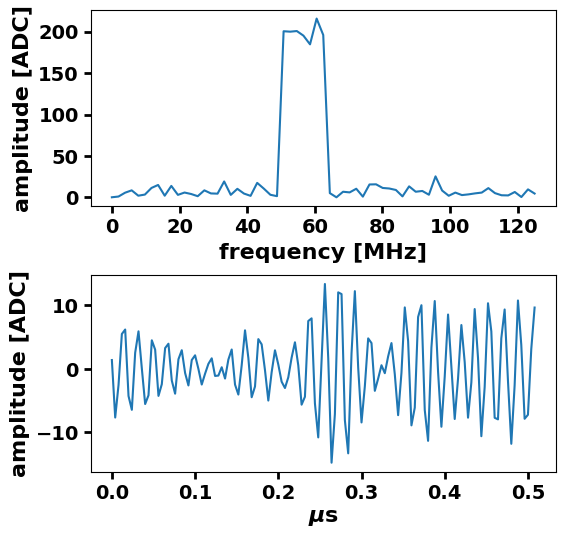

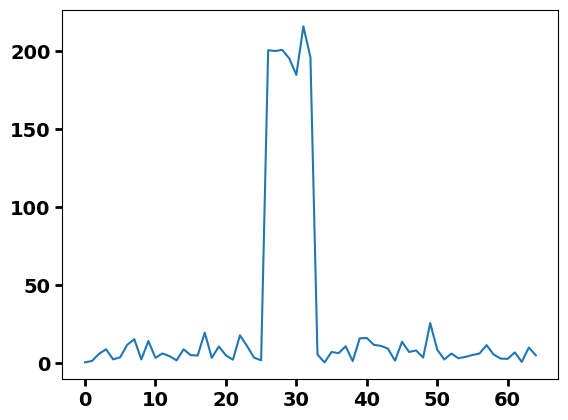

In [8]:

# create a broad band noise trace
bb_spec=np.zeros(65)
bb_spec[26:33] = 200

std_dev = 10  # Standard deviation

# Randomize the array values using a normal distribution
bb_spec = bb_spec + std_dev * np.random.randn(len(bb_spec))
bb_spec = np.abs(bb_spec)

bb_tt = np.real(ifft(one_sided_2_complex_two_sided(bb_spec)))

fx_bb = np.arange(0, bb_spec.size)/(2*(bb_spec.size-1)/250)
tx_bb = np.arange(bb_tt.size)/250

fig, ax = plt.subplots(2,1, figsize=(6,6))

ax[0].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("amplitude [ADC]")
ax[1].set_ylabel("amplitude [ADC]")
ax[1].set_xlabel("$\mu$s")

ax[0].plot(fx_bb, bb_spec)
ax[1].plot(tx_bb, bb_tt)

fig.subplots_adjust(hspace=0.35)

fig, ax = plt.subplots()
ax.plot(np.abs(rfft(bb_tt)))

In [9]:
# add broad band pulse to the time trace
time_trace_e = time_trace.copy()
time_trace_e[np.arange(1024, 1024+bb_tt.size)] = time_trace_e[np.arange(1024, 1024+bb_tt.size)] + bb_tt

rspectrum_e = np.abs(np.fft.rfft(time_trace_e))
rspectrum_w_e = np.abs(np.fft.rfft(time_trace_e*win))


In [10]:
def show_plots(time_trace, show_window_func=True):
    rspectrum = np.abs(np.fft.rfft(time_trace))
    rspectrum_w = np.abs(np.fft.rfft(time_trace * win))
    Aw = N / np.sum(win) / np.sqrt(2)

    e_tt = get_energy_from_time_trace(time_trace)
    e_spec = get_energy_from_one_sided_spectrum(rspectrum)
    e_spec_w = get_energy_from_one_sided_spectrum(rspectrum_w * Aw)

    fig, ax = plt.subplots(2, 1, figsize=(6, 6))

    mu = 1e6
    ax[0].plot(
        tx * mu, time_trace, label="no window: E={:.1f} a.u.".format(e_tt), alpha=0.7
    )
    ax[0].plot(tx * mu, time_trace * win, label="windowed", alpha=0.7, c='r')
    
    if show_window_func:
        ax[0].plot(tx * mu, win * 10, label="window func. x10", alpha=1, c='g', lw=2)

    ax[1].plot(
        fx , rspectrum, label="no window:         E={:.1f} a.u.".format(e_spec), alpha=0.7
    )

    ax[1].plot(
        fx ,
        rspectrum_w * Aw,
        label="windowed & A$_w$: E={:.1f} a.u.".format(e_spec_w),
        alpha=0.7,
        c='r'
    )

    display(
        get_energy_from_time_trace(time_trace),
        get_energy_from_one_sided_spectrum(rspectrum),
        get_energy_from_one_sided_spectrum(rspectrum_w * Aw),
    )

    ax[0].set_xlabel("$\mu$s")
    ax[1].set_xlabel("frequency [MHz]")
    ax[0].set_ylabel("amplitude [ADC]")
    ax[1].set_ylabel("amplitude [ADC]")
    ax[0].legend()
    ax[1].legend()
    ylims = ax[0].get_ylim()
    
    ax[0].set_ylim(-abs(np.max(ylims)*2), abs(np.max(ylims))*1.5)
    ylims = ax[1].get_ylim()
    ax[1].set_ylim(ylims[0], ylims[1]*1.4)
    ax[1].set_xlim(20, 90)
    
    fig.subplots_adjust(hspace=0.3)

1332.5858173370361

1332.5858173370361

1312.674415864144

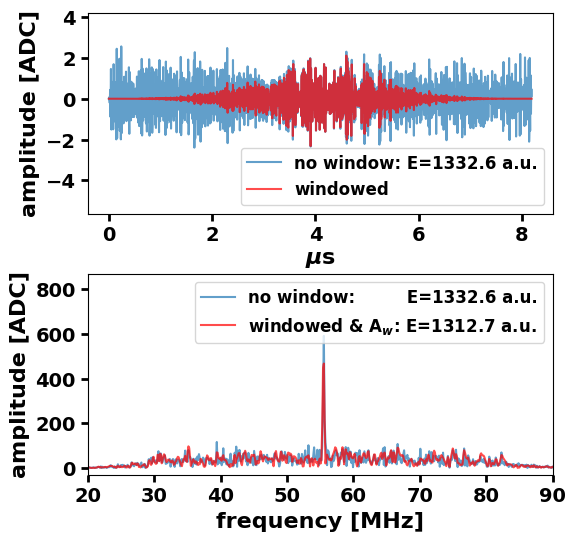

In [11]:
# trace without the broad band pulse
show_plots(time_trace, show_window_func=False)

5709.23198318932

5709.23198318932

16995.217867776955

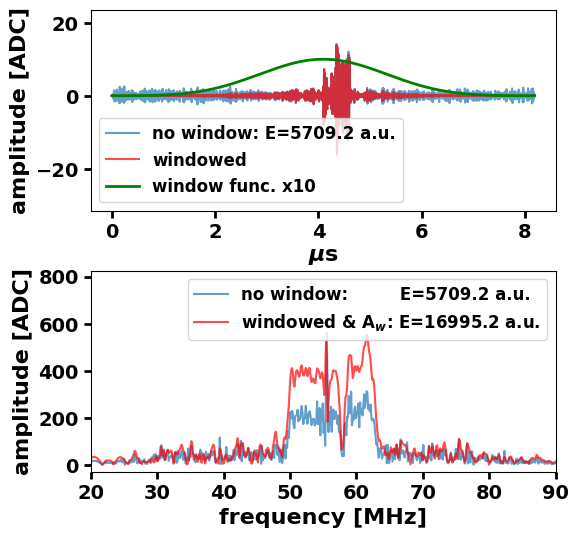

In [12]:
# trace with the broad band pulse
time_trace_e = time_trace.copy()
time_trace_e[np.arange(1024, 1024+bb_tt.size)] = time_trace_e[np.arange(1024, 1024+bb_tt.size)] + bb_tt
show_plots(time_trace_e)

5709.23198318932

5709.23198318932

1735.5628301299691

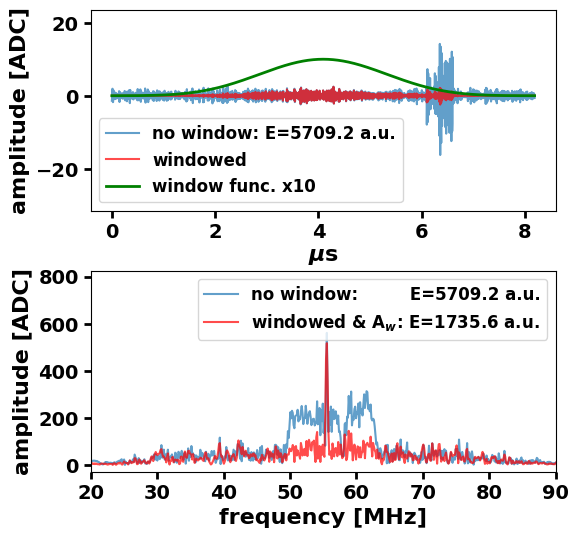

In [13]:
# rolled trace to shift the broad band pulse
show_plots(np.roll(time_trace_e, 500))

The learning here is that a amplitudes of a trace with broad band pulse cannot be safely corrected
after the window function because the window function is symmetric and the broad band pulse appearing 
in random parts of the trace will be each time differently supressed by the window function.

Note that the energy of the trace is after the rolling of the trace still the same when no window is used.

## Distributions of the energy ratios of not windowed spectra and windowed spectra with amplitude correction

In [14]:
def get_averaged_spectra_and_diffs(arr):
    diffs = np.array([])
    n, N = arr.shape
    avr_rspectrum = 0
    avr_rspectrum_w = 0
    win = blackmanharris(N)
    Aw = N / np.sum(win) / np.sqrt(2)
    for i in range(n):
        time_trace = arr[i, :]
        rspectrum = np.abs(np.fft.rfft(time_trace))
        rspectrum_w = np.abs(np.fft.rfft(time_trace * win))
        diffs = np.append(
            diffs,
            get_energy_from_time_trace(time_trace)
            / get_energy_from_one_sided_spectrum(rspectrum_w * Aw),
        )
        avr_rspectrum += rspectrum
        avr_rspectrum_w += rspectrum_w

    avr_rspectrum /= n
    avr_rspectrum_w /= n
    return avr_rspectrum, avr_rspectrum_w, diffs


def show_results(
    avr_rspectrum,
    avr_rspectrum_w,
    diffs,
    histo_edge=2,
    N=2048,
    bins=None,
    xax_min=None,
    xax_max=None,
    xlim= [None, None]
):
    fig, ax = plt.subplots()
    fx = np.fft.rfftfreq(N, 1 / fs_Hz) / 1e6

    if bins == None:
        bins = linspace_with_middle_value(
            np.mean(diffs), histo_edge * np.std(diffs), 20
        )
    ax.hist(diffs, bins=bins)
    # Calculate mean and standard deviation
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)

    print(mean_diff)
    print(std_diff)

    # Add text box with mean and standard deviation
    text_box = f"$\mu$: {mean_diff:.2f}\n$\sigma$: {std_diff:.2f}"
    ax.text(
        0.95,
        0.95,
        text_box,
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    ax.set_xlim(xax_min, xax_max)
    ax.set_xlabel(
        r"$\frac{\mathrm{energy: \ spectrum \ with \ no\ window}}{\mathrm{energy:spectrum \ with\ window,\ amplitudes\ corrected}}$"
    )
    ax.set_ylabel("entries")

    fig, ax = plt.subplots()

    ax.plot(fx, voltageAmp2dB(avr_rspectrum), alpha=0.7, label="no window")
    ax.plot(fx, voltageAmp2dB(avr_rspectrum_w), alpha=0.7, label="with window", c='g')
    ax.plot(
        fx,
        voltageAmp2dB(avr_rspectrum_w * Aw),
        alpha=0.7,
        label="with window " + "\n" + "and corrected", c='r'
    )
    
    
    # ax.axes.axvspan(30,80, color='b', alpha=0.1)
    ax.set_xlim(*xlim)
    autoscale_y(ax)     
    
    ax.set_xlabel("frequency [MHz]")
    ax.set_ylabel("dB")
    ax.legend()

### Simple traces

In [15]:
# create a set of 1000 time traces
n = 1000
avr_rspectrum = 0
avr_rspectrum_w = 0
time_traces = make_simple_time_trace()
for i in range(n-1):
    time_traces = np.vstack((time_traces, make_simple_time_trace()))

In [16]:
# calculate energy ratios of unwindowed spectra and windowed with amplitude correction
# and average spectra
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(time_traces)
diffs1 = diffs
label4final_histo = ['simple traces']

1.0018217390344406
0.060064483377693656


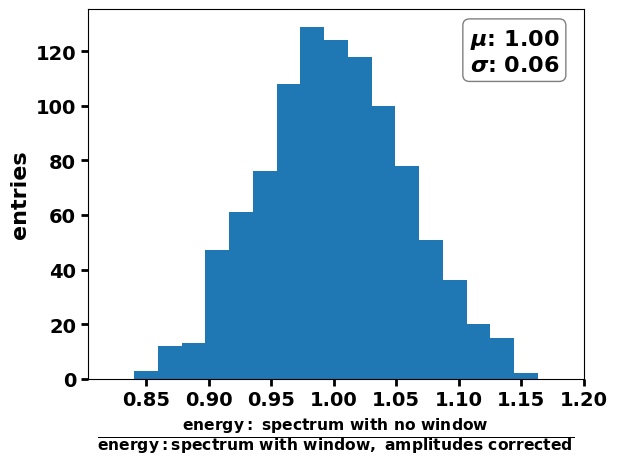

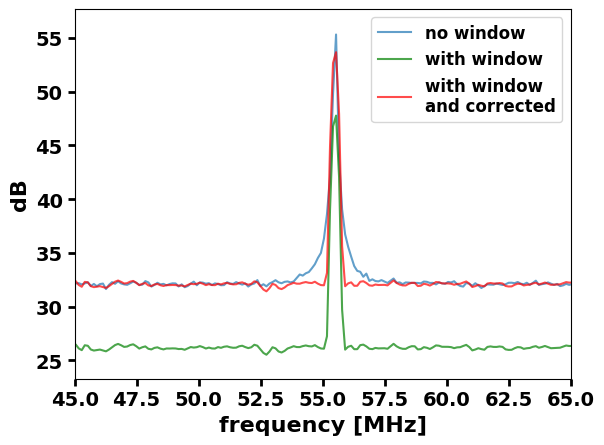

In [17]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3, xlim=[45, 65])

In [18]:
# create a set of 1000 time traces with bb pulses
n = 1000
avr_rspectrum = 0
avr_rspectrum_w = 0
time_traces = make_simple_time_trace()
for i in range(n-1):
    time_trace = make_simple_time_trace()
    time_trace[0:bb_tt.size] = time_trace[0:bb_tt.size] + bb_tt
    time_trace = np.roll(time_trace_e, random.randint(0, 2048 - bb_tt.size) )
    time_traces = np.vstack((time_traces, time_trace))

In [19]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(time_traces)

2.5347509214172477
1.5478178215950311


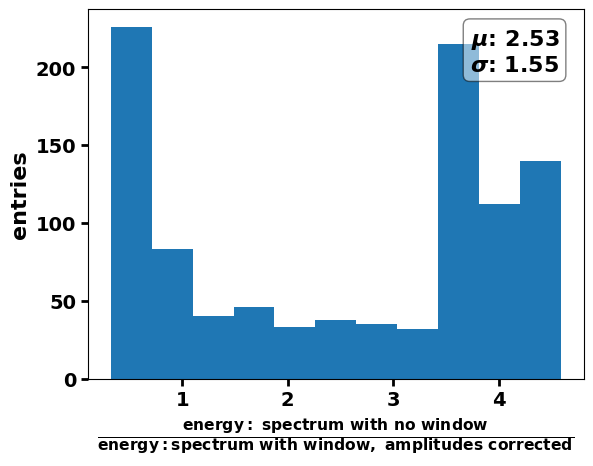

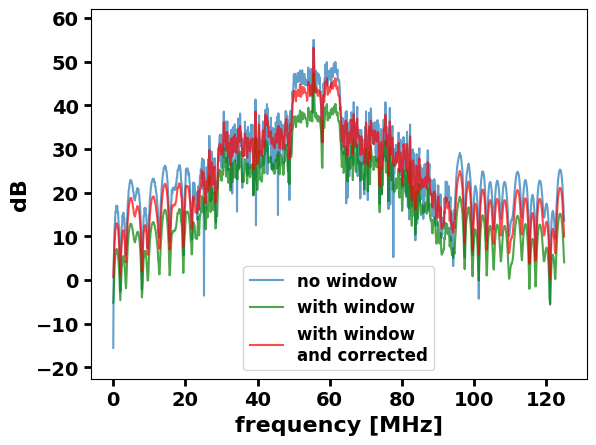

In [20]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3, bins='auto')
# ,xax_min=-10, xax_max=80)

### Mock traces

In [21]:
# read HW response
hw_file_path = "./antenna_setup_files/HardwareProfileList_realistic.xml"
hw_dict = read_hw_file(hw_file_path, interp_args={"fill_value": "extrapolate"})

hw_reponse_1 = hw_dict["RResponse"]["LNA"]
hw_reponse_2 = hw_dict["RResponse"]["digitizer"]
hw_reponse_3 = hw_dict["RResponse"]["cable_fromLNA2digitizer"]
hw_reponse_4 = hw_dict["RResponse"]["impedance_matching_EW"]


# merge all hw responses to one function
def hw_response_func(x):
    return dB2PowerAmp(
        hw_reponse_1(x) + hw_reponse_2(x) + hw_reponse_3(x) + hw_reponse_4(x)
    )


# impedance function
impedance_func = hw_dict["IImpedance"][
    "antenna_EW"
]

# read sidereal voltage square spectral density
sidereal_voltage2_density_DF = pd.read_csv(
    "./voltage2_density/voltage2_density_Salla_EW_GSM16.csv",
    index_col=0,
)
sidereal_voltage2_density_DF.columns = sidereal_voltage2_density_DF.columns.astype(
    float
)

<?xml version="1.0" encoding="iso-8859-1"?>
<Element HardwareProfileList at 0x7fb9f197eb40>


In [22]:
mock_trace_generator = Mock_trace_generator(
    sidereal_voltage2_density_DF=sidereal_voltage2_density_DF,
    hw_response_func=hw_response_func,
    impedance_func=impedance_func,
    voltage2ADC=2048,
    time_trace_size=2048,
    sampling_frequency_MHz=250,
)
freq_MHz_bins = mock_trace_generator.get_frequency_bins()

In [23]:
piko = 1e-12
additional_noise = 5e-4*piko
debug_spectra_dict = mock_trace_generator.generate_mock_trace(
    1,
    lst=15,
    temp_celsius=30,
    nbi={"67.2": 1},
    nbi_err=0.2,
    return_debug_dict=True,
    additional_noise=additional_noise,
)[0]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 302.14it/s]

In [24]:
number_of_traces = 1000
mock_traces_DF = mock_trace_generator.generate_mock_trace(
    number_of_traces,
    temp_celsius=[-10,30],
    additional_noise=additional_noise,
    nbi={"67.25": 1},
    nbi_err=0.3,
)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|▏                                         | 4/1000 [00:00<00:31, 31.88it/s]

  1%|▎                                         | 8/1000 [00:00<00:31, 31.91it/s]

  1%|▍                                        | 12/1000 [00:00<00:30, 31.89it/s]

  2%|▋                                        | 16/1000 [00:00<00:30, 31.84it/s]

  2%|▊                                        | 20/1000 [00:00<00:30, 31.84it/s]

  2%|▉                                        | 24/1000 [00:00<00:31, 31.33it/s]

  3%|█▏                                       | 28/1000 [00:00<00:31, 30.88it/s]

  3%|█▎                                       | 32/1000 [00:01<00:31, 31.19it/s]

  4%|█▍                                       | 36/1000 [00:01<00:30, 31.54it/s]

  4%|█▋                                       | 40/1000 [00:01<00:30, 31.75it/s]

  4%|█▊                                       | 44/1000 [00:01<00:29, 31.94it/s]

  5%|█▉                                       | 48/1000 [00:01<00:29, 32.01it/s]

  5%|██▏                                      | 52/1000 [00:01<00:29, 32.10it/s]

  6%|██▎                                      | 56/1000 [00:01<00:29, 32.14it/s]

  6%|██▍                                      | 60/1000 [00:01<00:29, 32.20it/s]

  6%|██▌                                      | 64/1000 [00:02<00:29, 32.17it/s]

  7%|██▊                                      | 68/1000 [00:02<00:28, 32.22it/s]

  7%|██▉                                      | 72/1000 [00:02<00:28, 32.27it/s]

  8%|███                                      | 76/1000 [00:02<00:33, 27.88it/s]

  8%|███▎                                     | 80/1000 [00:02<00:31, 29.00it/s]

  8%|███▍                                     | 84/1000 [00:02<00:31, 29.53it/s]

  9%|███▌                                     | 88/1000 [00:02<00:30, 30.06it/s]

  9%|███▊                                     | 92/1000 [00:02<00:29, 30.63it/s]

 10%|███▉                                     | 96/1000 [00:03<00:29, 31.02it/s]

 10%|████                                    | 100/1000 [00:03<00:28, 31.29it/s]

 10%|████▏                                   | 104/1000 [00:03<00:28, 31.48it/s]

 11%|████▎                                   | 108/1000 [00:03<00:28, 31.65it/s]

 11%|████▍                                   | 112/1000 [00:03<00:27, 31.77it/s]

 12%|████▋                                   | 116/1000 [00:03<00:27, 31.83it/s]

 12%|████▊                                   | 120/1000 [00:03<00:27, 31.90it/s]

 12%|████▉                                   | 124/1000 [00:03<00:27, 31.89it/s]

 13%|█████                                   | 128/1000 [00:04<00:27, 31.89it/s]

 13%|█████▎                                  | 132/1000 [00:04<00:27, 31.93it/s]

 14%|█████▍                                  | 136/1000 [00:04<00:27, 31.96it/s]

 14%|█████▌                                  | 140/1000 [00:04<00:26, 31.92it/s]

 14%|█████▊                                  | 144/1000 [00:04<00:26, 31.85it/s]

 15%|█████▉                                  | 148/1000 [00:04<00:26, 31.79it/s]

 15%|██████                                  | 152/1000 [00:04<00:26, 31.83it/s]

 16%|██████▏                                 | 156/1000 [00:04<00:26, 31.89it/s]

 16%|██████▍                                 | 160/1000 [00:05<00:26, 31.81it/s]

 16%|██████▌                                 | 164/1000 [00:05<00:26, 31.85it/s]

 17%|██████▋                                 | 168/1000 [00:05<00:26, 31.88it/s]

 17%|██████▉                                 | 172/1000 [00:05<00:25, 31.92it/s]

 18%|███████                                 | 176/1000 [00:05<00:25, 31.90it/s]

 18%|███████▏                                | 180/1000 [00:05<00:26, 31.46it/s]

 18%|███████▎                                | 184/1000 [00:05<00:25, 31.59it/s]

 19%|███████▌                                | 188/1000 [00:05<00:25, 31.68it/s]

 19%|███████▋                                | 192/1000 [00:06<00:25, 31.74it/s]

 20%|███████▊                                | 196/1000 [00:06<00:25, 31.79it/s]

 20%|████████                                | 200/1000 [00:06<00:25, 31.81it/s]

 20%|████████▏                               | 204/1000 [00:06<00:24, 31.86it/s]

 21%|████████▎                               | 208/1000 [00:06<00:24, 31.91it/s]

 21%|████████▍                               | 212/1000 [00:06<00:24, 31.58it/s]

 22%|████████▋                               | 216/1000 [00:06<00:24, 31.69it/s]

 22%|████████▊                               | 220/1000 [00:07<00:27, 28.16it/s]

 22%|████████▉                               | 224/1000 [00:07<00:26, 29.21it/s]

 23%|█████████                               | 228/1000 [00:07<00:25, 29.99it/s]

 23%|█████████▎                              | 232/1000 [00:07<00:25, 30.52it/s]

 24%|█████████▍                              | 236/1000 [00:07<00:24, 30.84it/s]

 24%|█████████▌                              | 240/1000 [00:07<00:24, 31.04it/s]

 24%|█████████▊                              | 244/1000 [00:07<00:24, 31.21it/s]

 25%|█████████▉                              | 248/1000 [00:07<00:23, 31.35it/s]

 25%|██████████                              | 252/1000 [00:08<00:23, 31.44it/s]

 26%|██████████▏                             | 256/1000 [00:08<00:23, 31.56it/s]

 26%|██████████▍                             | 260/1000 [00:08<00:23, 31.63it/s]

 26%|██████████▌                             | 264/1000 [00:08<00:23, 31.66it/s]

 27%|██████████▋                             | 268/1000 [00:08<00:23, 31.40it/s]

 27%|██████████▉                             | 272/1000 [00:08<00:23, 31.51it/s]

 28%|███████████                             | 276/1000 [00:08<00:22, 31.59it/s]

 28%|███████████▏                            | 280/1000 [00:08<00:22, 31.62it/s]

 28%|███████████▎                            | 284/1000 [00:09<00:22, 31.66it/s]

 29%|███████████▌                            | 288/1000 [00:09<00:22, 31.68it/s]

 29%|███████████▋                            | 292/1000 [00:09<00:22, 31.68it/s]

 30%|███████████▊                            | 296/1000 [00:09<00:22, 31.67it/s]

 30%|████████████                            | 300/1000 [00:09<00:22, 31.69it/s]

 30%|████████████▏                           | 304/1000 [00:09<00:21, 31.76it/s]

 31%|████████████▎                           | 308/1000 [00:09<00:22, 31.28it/s]

 31%|████████████▍                           | 312/1000 [00:09<00:21, 31.42it/s]

 32%|████████████▋                           | 316/1000 [00:10<00:21, 31.47it/s]

 32%|████████████▊                           | 320/1000 [00:10<00:21, 31.53it/s]

 32%|████████████▉                           | 324/1000 [00:10<00:21, 31.43it/s]

 33%|█████████████                           | 328/1000 [00:10<00:21, 31.48it/s]

 33%|█████████████▎                          | 332/1000 [00:10<00:21, 31.52it/s]

 34%|█████████████▍                          | 336/1000 [00:10<00:21, 31.20it/s]

 34%|█████████████▌                          | 340/1000 [00:10<00:21, 31.15it/s]

 34%|█████████████▊                          | 344/1000 [00:10<00:20, 31.28it/s]

 35%|█████████████▉                          | 348/1000 [00:11<00:20, 31.36it/s]

 35%|██████████████                          | 352/1000 [00:11<00:20, 31.45it/s]

 36%|██████████████▏                         | 356/1000 [00:11<00:20, 31.30it/s]

 36%|██████████████▍                         | 360/1000 [00:11<00:20, 31.29it/s]

 36%|██████████████▌                         | 364/1000 [00:11<00:20, 31.33it/s]

 37%|██████████████▋                         | 368/1000 [00:11<00:20, 31.28it/s]

 37%|██████████████▉                         | 372/1000 [00:11<00:20, 30.98it/s]

 38%|███████████████                         | 376/1000 [00:11<00:20, 31.17it/s]

 38%|███████████████▏                        | 380/1000 [00:12<00:19, 31.29it/s]

 38%|███████████████▎                        | 384/1000 [00:12<00:19, 31.45it/s]

 39%|███████████████▌                        | 388/1000 [00:12<00:19, 31.42it/s]

 39%|███████████████▋                        | 392/1000 [00:12<00:19, 31.45it/s]

 40%|███████████████▊                        | 396/1000 [00:12<00:19, 31.52it/s]

 40%|████████████████                        | 400/1000 [00:12<00:19, 31.56it/s]

 40%|████████████████▏                       | 404/1000 [00:12<00:18, 31.53it/s]

 41%|████████████████▎                       | 408/1000 [00:12<00:18, 31.49it/s]

 41%|████████████████▍                       | 412/1000 [00:13<00:18, 32.20it/s]

 42%|████████████████▋                       | 416/1000 [00:13<00:17, 32.60it/s]

 42%|████████████████▊                       | 420/1000 [00:13<00:17, 32.80it/s]

 42%|████████████████▉                       | 424/1000 [00:13<00:17, 32.74it/s]

 43%|█████████████████                       | 428/1000 [00:13<00:17, 32.66it/s]

 43%|█████████████████▎                      | 432/1000 [00:13<00:17, 32.61it/s]

 44%|█████████████████▍                      | 436/1000 [00:13<00:17, 32.67it/s]

 44%|█████████████████▌                      | 440/1000 [00:13<00:17, 32.68it/s]

 44%|█████████████████▊                      | 444/1000 [00:14<00:16, 32.71it/s]

 45%|█████████████████▉                      | 448/1000 [00:14<00:16, 32.75it/s]

 45%|██████████████████                      | 452/1000 [00:14<00:16, 32.80it/s]

 46%|██████████████████▏                     | 456/1000 [00:14<00:16, 32.84it/s]

 46%|██████████████████▍                     | 460/1000 [00:14<00:16, 32.93it/s]

 46%|██████████████████▌                     | 464/1000 [00:14<00:16, 32.90it/s]

 47%|██████████████████▋                     | 468/1000 [00:14<00:16, 32.87it/s]

 47%|██████████████████▉                     | 472/1000 [00:14<00:16, 32.94it/s]

 48%|███████████████████                     | 476/1000 [00:15<00:15, 32.93it/s]

 48%|███████████████████▏                    | 480/1000 [00:15<00:15, 32.82it/s]

 48%|███████████████████▎                    | 484/1000 [00:15<00:15, 32.81it/s]

 49%|███████████████████▌                    | 488/1000 [00:15<00:15, 32.88it/s]

 49%|███████████████████▋                    | 492/1000 [00:15<00:15, 32.88it/s]

 50%|███████████████████▊                    | 496/1000 [00:15<00:15, 32.86it/s]

 50%|████████████████████                    | 500/1000 [00:15<00:15, 32.47it/s]

 50%|████████████████████▏                   | 504/1000 [00:15<00:15, 32.54it/s]

 51%|████████████████████▎                   | 508/1000 [00:16<00:15, 32.65it/s]

 51%|████████████████████▍                   | 512/1000 [00:16<00:14, 32.73it/s]

 52%|████████████████████▋                   | 516/1000 [00:16<00:14, 32.77it/s]

 52%|████████████████████▊                   | 520/1000 [00:16<00:14, 32.75it/s]

 52%|████████████████████▉                   | 524/1000 [00:16<00:14, 32.69it/s]

 53%|█████████████████████                   | 528/1000 [00:16<00:14, 32.59it/s]

 53%|█████████████████████▎                  | 532/1000 [00:16<00:14, 32.59it/s]

 54%|█████████████████████▍                  | 536/1000 [00:16<00:14, 32.69it/s]

 54%|█████████████████████▌                  | 540/1000 [00:17<00:14, 32.71it/s]

 54%|█████████████████████▊                  | 544/1000 [00:17<00:13, 32.72it/s]

 55%|█████████████████████▉                  | 548/1000 [00:17<00:13, 32.75it/s]

 55%|██████████████████████                  | 552/1000 [00:17<00:13, 32.73it/s]

 56%|██████████████████████▏                 | 556/1000 [00:17<00:13, 32.78it/s]

 56%|██████████████████████▍                 | 560/1000 [00:17<00:13, 32.80it/s]

 56%|██████████████████████▌                 | 564/1000 [00:17<00:13, 32.56it/s]

 57%|██████████████████████▋                 | 568/1000 [00:17<00:13, 32.53it/s]

 57%|██████████████████████▉                 | 572/1000 [00:17<00:13, 32.58it/s]

 58%|███████████████████████                 | 576/1000 [00:18<00:13, 32.60it/s]

 58%|███████████████████████▏                | 580/1000 [00:18<00:12, 32.63it/s]

 58%|███████████████████████▎                | 584/1000 [00:18<00:12, 32.64it/s]

 59%|███████████████████████▌                | 588/1000 [00:18<00:12, 32.64it/s]

 59%|███████████████████████▋                | 592/1000 [00:18<00:12, 32.43it/s]

 60%|███████████████████████▊                | 596/1000 [00:18<00:12, 32.35it/s]

 60%|████████████████████████                | 600/1000 [00:18<00:12, 32.31it/s]

 60%|████████████████████████▏               | 604/1000 [00:19<00:12, 30.97it/s]

 61%|████████████████████████▎               | 608/1000 [00:19<00:14, 27.26it/s]

 61%|████████████████████████▍               | 611/1000 [00:19<00:15, 25.50it/s]

 61%|████████████████████████▌               | 614/1000 [00:19<00:15, 24.23it/s]

 62%|████████████████████████▋               | 617/1000 [00:19<00:16, 23.21it/s]

 62%|████████████████████████▊               | 620/1000 [00:19<00:16, 22.48it/s]

 62%|████████████████████████▉               | 623/1000 [00:19<00:17, 21.32it/s]

 63%|█████████████████████████               | 626/1000 [00:20<00:16, 23.24it/s]

 63%|█████████████████████████▏              | 630/1000 [00:20<00:14, 26.07it/s]

 63%|█████████████████████████▎              | 634/1000 [00:20<00:13, 28.04it/s]

 64%|█████████████████████████▌              | 638/1000 [00:20<00:12, 29.47it/s]

 64%|█████████████████████████▋              | 641/1000 [00:20<00:13, 26.57it/s]

 64%|█████████████████████████▊              | 645/1000 [00:20<00:12, 28.45it/s]

 65%|█████████████████████████▉              | 649/1000 [00:20<00:11, 29.76it/s]

 65%|██████████████████████████              | 653/1000 [00:20<00:11, 30.69it/s]

 66%|██████████████████████████▎             | 657/1000 [00:21<00:10, 31.34it/s]

 66%|██████████████████████████▍             | 661/1000 [00:21<00:10, 31.79it/s]

 66%|██████████████████████████▌             | 665/1000 [00:21<00:10, 32.06it/s]

 67%|██████████████████████████▊             | 669/1000 [00:21<00:10, 32.28it/s]

 67%|██████████████████████████▉             | 673/1000 [00:21<00:10, 32.43it/s]

 68%|███████████████████████████             | 677/1000 [00:21<00:09, 32.60it/s]

 68%|███████████████████████████▏            | 681/1000 [00:21<00:09, 32.66it/s]

 68%|███████████████████████████▍            | 685/1000 [00:21<00:09, 32.61it/s]

 69%|███████████████████████████▌            | 689/1000 [00:21<00:09, 32.60it/s]

 69%|███████████████████████████▋            | 693/1000 [00:22<00:09, 32.70it/s]

 70%|███████████████████████████▉            | 697/1000 [00:22<00:09, 32.71it/s]

 70%|████████████████████████████            | 701/1000 [00:22<00:09, 32.74it/s]

 70%|████████████████████████████▏           | 705/1000 [00:22<00:08, 32.80it/s]

 71%|████████████████████████████▎           | 709/1000 [00:22<00:08, 32.66it/s]

 71%|████████████████████████████▌           | 713/1000 [00:22<00:08, 32.64it/s]

 72%|████████████████████████████▋           | 717/1000 [00:22<00:08, 32.40it/s]

 72%|████████████████████████████▊           | 721/1000 [00:22<00:08, 32.43it/s]

 72%|█████████████████████████████           | 725/1000 [00:23<00:08, 32.46it/s]

 73%|█████████████████████████████▏          | 729/1000 [00:23<00:08, 32.50it/s]

 73%|█████████████████████████████▎          | 733/1000 [00:23<00:08, 32.61it/s]

 74%|█████████████████████████████▍          | 737/1000 [00:23<00:08, 32.66it/s]

 74%|█████████████████████████████▋          | 741/1000 [00:23<00:07, 32.56it/s]

 74%|█████████████████████████████▊          | 745/1000 [00:23<00:07, 32.58it/s]

 75%|█████████████████████████████▉          | 749/1000 [00:23<00:07, 32.65it/s]

 75%|██████████████████████████████          | 753/1000 [00:23<00:07, 32.56it/s]

 76%|██████████████████████████████▎         | 757/1000 [00:24<00:07, 32.44it/s]

 76%|██████████████████████████████▍         | 761/1000 [00:24<00:07, 32.46it/s]

 76%|██████████████████████████████▌         | 765/1000 [00:24<00:07, 32.52it/s]

 77%|██████████████████████████████▊         | 769/1000 [00:24<00:07, 32.36it/s]

 77%|██████████████████████████████▉         | 773/1000 [00:24<00:06, 32.45it/s]

 78%|███████████████████████████████         | 777/1000 [00:24<00:06, 32.48it/s]

 78%|███████████████████████████████▏        | 781/1000 [00:24<00:06, 32.50it/s]

 78%|███████████████████████████████▍        | 785/1000 [00:24<00:06, 32.41it/s]

 79%|███████████████████████████████▌        | 789/1000 [00:25<00:06, 32.41it/s]

 79%|███████████████████████████████▋        | 793/1000 [00:25<00:06, 32.43it/s]

 80%|███████████████████████████████▉        | 797/1000 [00:25<00:06, 32.41it/s]

 80%|████████████████████████████████        | 801/1000 [00:25<00:06, 32.41it/s]

 80%|████████████████████████████████▏       | 805/1000 [00:25<00:06, 32.42it/s]

 81%|████████████████████████████████▎       | 809/1000 [00:25<00:05, 32.46it/s]

 81%|████████████████████████████████▌       | 813/1000 [00:25<00:05, 32.38it/s]

 82%|████████████████████████████████▋       | 817/1000 [00:25<00:05, 32.32it/s]

 82%|████████████████████████████████▊       | 821/1000 [00:26<00:05, 32.27it/s]

 82%|█████████████████████████████████       | 825/1000 [00:26<00:05, 32.25it/s]

 83%|█████████████████████████████████▏      | 829/1000 [00:26<00:05, 32.33it/s]

 83%|█████████████████████████████████▎      | 833/1000 [00:26<00:05, 32.38it/s]

 84%|█████████████████████████████████▍      | 837/1000 [00:26<00:05, 32.41it/s]

 84%|█████████████████████████████████▋      | 841/1000 [00:26<00:04, 32.41it/s]

 84%|█████████████████████████████████▊      | 845/1000 [00:26<00:04, 32.44it/s]

 85%|█████████████████████████████████▉      | 849/1000 [00:26<00:04, 32.41it/s]

 85%|██████████████████████████████████      | 853/1000 [00:27<00:05, 28.71it/s]

 86%|██████████████████████████████████▎     | 857/1000 [00:27<00:04, 29.70it/s]

 86%|██████████████████████████████████▍     | 861/1000 [00:27<00:04, 30.50it/s]

 86%|██████████████████████████████████▌     | 865/1000 [00:27<00:04, 31.09it/s]

 87%|██████████████████████████████████▊     | 869/1000 [00:27<00:04, 31.50it/s]

 87%|██████████████████████████████████▉     | 873/1000 [00:27<00:04, 31.72it/s]

 88%|███████████████████████████████████     | 877/1000 [00:27<00:03, 31.83it/s]

 88%|███████████████████████████████████▏    | 881/1000 [00:27<00:03, 32.01it/s]

 88%|███████████████████████████████████▍    | 885/1000 [00:28<00:03, 32.11it/s]

 89%|███████████████████████████████████▌    | 889/1000 [00:28<00:03, 32.12it/s]

 89%|███████████████████████████████████▋    | 893/1000 [00:28<00:03, 32.23it/s]

 90%|███████████████████████████████████▉    | 897/1000 [00:28<00:03, 32.25it/s]

 90%|████████████████████████████████████    | 901/1000 [00:28<00:03, 32.20it/s]

 90%|████████████████████████████████████▏   | 905/1000 [00:28<00:02, 32.16it/s]

 91%|████████████████████████████████████▎   | 909/1000 [00:28<00:02, 32.18it/s]

 91%|████████████████████████████████████▌   | 913/1000 [00:28<00:02, 32.11it/s]

 92%|████████████████████████████████████▋   | 917/1000 [00:29<00:02, 32.09it/s]

 92%|████████████████████████████████████▊   | 921/1000 [00:29<00:02, 32.14it/s]

 92%|█████████████████████████████████████   | 925/1000 [00:29<00:02, 32.16it/s]

 93%|█████████████████████████████████████▏  | 929/1000 [00:29<00:02, 32.20it/s]

 93%|█████████████████████████████████████▎  | 933/1000 [00:29<00:02, 32.23it/s]

 94%|█████████████████████████████████████▍  | 937/1000 [00:29<00:01, 32.13it/s]

 94%|█████████████████████████████████████▋  | 941/1000 [00:29<00:01, 32.09it/s]

 94%|█████████████████████████████████████▊  | 945/1000 [00:29<00:01, 32.08it/s]

 95%|█████████████████████████████████████▉  | 949/1000 [00:30<00:01, 32.11it/s]

 95%|██████████████████████████████████████  | 953/1000 [00:30<00:01, 32.18it/s]

 96%|██████████████████████████████████████▎ | 957/1000 [00:30<00:01, 32.21it/s]

 96%|██████████████████████████████████████▍ | 961/1000 [00:30<00:01, 32.20it/s]

 96%|██████████████████████████████████████▌ | 965/1000 [00:30<00:01, 32.20it/s]

 97%|██████████████████████████████████████▊ | 969/1000 [00:30<00:00, 32.22it/s]

 97%|██████████████████████████████████████▉ | 973/1000 [00:30<00:00, 32.20it/s]

 98%|███████████████████████████████████████ | 977/1000 [00:30<00:00, 32.19it/s]

 98%|███████████████████████████████████████▏| 981/1000 [00:31<00:00, 32.16it/s]

 98%|███████████████████████████████████████▍| 985/1000 [00:31<00:00, 32.21it/s]

 99%|███████████████████████████████████████▌| 989/1000 [00:31<00:00, 32.12it/s]

 99%|███████████████████████████████████████▋| 993/1000 [00:31<00:00, 32.09it/s]

100%|███████████████████████████████████████▉| 997/1000 [00:31<00:00, 28.47it/s]

100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.53it/s]

In [25]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(mock_traces_DF.iloc[:,2:].values)
diffs2 = diffs
label4final_histo.append('mock traces')

0.9997583861051457
0.04984380100134047


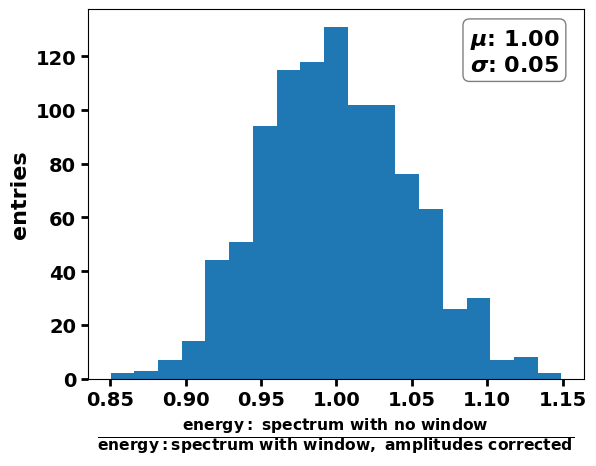

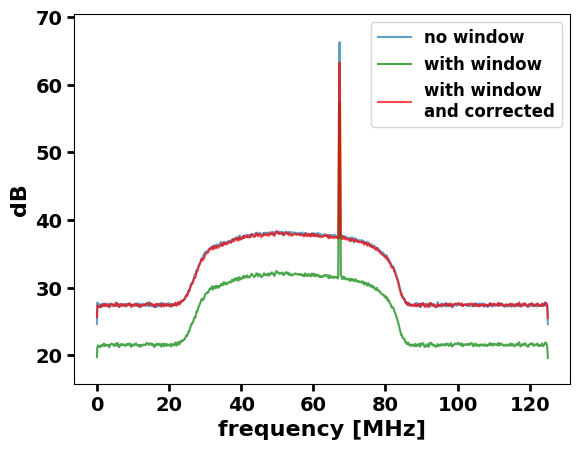

In [26]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3)

In [27]:
mock_traces_with_BB_DF = mock_traces_DF.copy(deep=True)
for i in range(mock_traces_with_BB_DF.index.size):
    start_bb_index = np.random.randint(0, 2048-40)
    time_trace = mock_traces_with_BB_DF.iloc[i,2:].values
    time_trace[0:bb_tt.size] = time_trace[0:bb_tt.size] + bb_tt
    time_trace = np.roll(time_trace_e, random.randint(0, 2048 - bb_tt.size) )
    mock_traces_with_BB_DF.iloc[i,2:] = time_trace

In [28]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(mock_traces_with_BB_DF.iloc[:,2:].values)
diffs3 = diffs
label4final_histo.append('mock traces with BB pulse')

2.52938808657187
1.5461405225345628


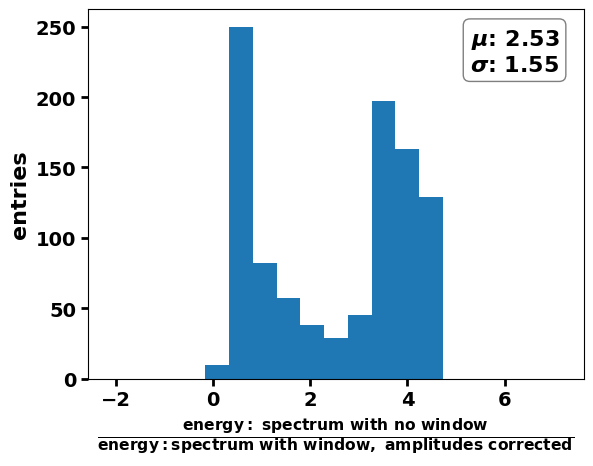

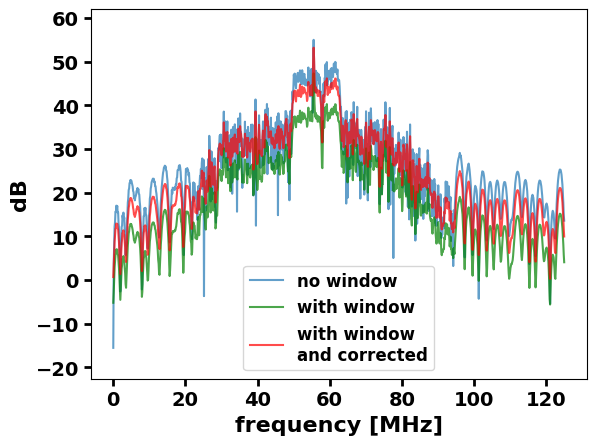

In [29]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3)

### Summary

simple traces
Mean and STD:0.0018, 0.0601
Truncated Mean and STD: 0.0018, 0.0601
******
mock traces
Mean and STD:-0.0002, 0.0498
Truncated Mean and STD: -0.0002, 0.0498
******
mock traces with BB pulse
Mean and STD:1.5294, 1.5461
Truncated Mean and STD: 1.5294, 1.5461
******


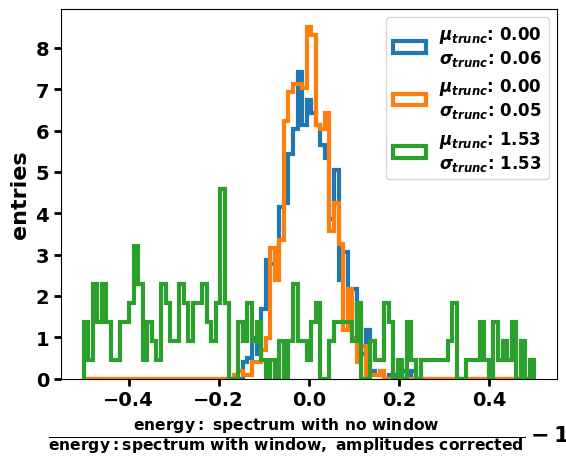

In [30]:
fig, ax = plt.subplots()
fx = np.fft.rfftfreq(N, 1 / fs_Hz) / 1e6

diffs_list = np.asarray([diffs1, diffs2, diffs3], dtype="object") - 1
# diffs_list = [diffs1, diffs2]

bins = np.histogram_bin_edges(np.concatenate(diffs_list), bins=20)


# if bins == None:
bins = linspace_with_middle_value(
    np.mean(np.concatenate(diffs_list)), 2 * np.std(np.concatenate(diffs_list)), 20
)

bins = np.linspace(0.5, 1.5, 100) - 1

for i, diffs in enumerate(diffs_list):
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_diff_trun, std_diff_trun = calculate_truncated_stats(diffs, 1, 99)
    label = (
        text_box
    ) = f"$\mu_{{trunc}}$: {round(mean_diff_trun,2)+0:.2f}\n$\sigma_{{trunc}}$: {round(std_diff_trun,2)+0:.2f}"
    ax.hist(diffs, bins=bins, alpha=1, density=True, histtype="step", lw=3, label=label)
    # Calculate mean and standard deviation
    print(label4final_histo[i])
    print('Mean and STD:{:.4f}, {:.4f}'.format(mean_diff, std_diff))
    print('Truncated Mean and STD: {:.4f}, {:.4f}'.format(mean_diff, std_diff))
    print("******")

# ax.set_xlim(xax_min, xax_max)
ax.set_xlabel(
    r"$\frac{\mathrm{energy: \ spectrum \ with \ no\ window}}{\mathrm{energy:spectrum \ with\ window,\ amplitudes\ corrected}} -1$"
)
ax.set_ylabel("entries")
ax.legend()

In [31]:
print('The colors corespond to')
print(label4final_histo)
print(', respectively.')

The colors corespond to
['simple traces', 'mock traces', 'mock traces with BB pulse']
, respectively.


CONCLUSION: The broad band pulse in the trace spoils the energy recovery.